# RNN learns phase code solution on the M3A task
This notebook documents an RNN learning the phase code solution when trained on the M3A task.

## Imports

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from flax.linen import initializers
import optax

from ctrnn_jax.model import CTRNNCell
from ctrnn_jax.training import ModelParameters, create_train_state
from ctrnn_jax.pca import compute_pca

from emergence_phase_codes.model import initialize_ctrnn
from emergence_phase_codes.training import train_model, plot_training_loss_accuracy
from emergence_phase_codes.task import ModuloNArithmetic
from emergence_phase_codes.pca import add_data

from emergence_phase_codes.animations.output import OutputAnimator
from emergence_phase_codes.animations.pca import PCATrajectoryAnimator, PCAPopulationAnimator
from emergence_phase_codes.animations.utils import interpolate_colors

In [2]:
key = random.PRNGKey(69)

## Configurable parameters

In [3]:
# Modulo3Arithmetic task parameters
BATCH_SIZE_M3A = 16

MOD = 3
CONGRUENT_NUMBER = 0
TIME_LENGTH = 50
NUM_TRIALS = 2500

TRIALS_PER_POS = 100
TRIALS_PER_NEG = 50

PULSE_CONFIG = {
    "num_pulses": 3,
    "pulse_window": 40,
    "pulse_buffer": 5,
    "pulse_gap": 5,
    "pulse_amplitude": 5,
}

INIT_ARRAY_M3A = jnp.ones([BATCH_SIZE_M3A, TIME_LENGTH, MOD])

In [4]:
# Configure model parameters
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 1
ALPHA = 1.0
NOISE_SCALAR = 0.05

In [5]:
# Configure training parameters
EPOCHS = 500
LEARNING_RATE = 1E-4
TIME_INDEX = -3
RATE_PENALTY = 1E-4

## Initialize MMA task

In [6]:
# Initialize task
key, task_key = random.split(key, num=2)
task = ModuloNArithmetic(
    task_key, 
    MOD,
    congruent_number=CONGRUENT_NUMBER,
    time_length=TIME_LENGTH,
    num_trials=NUM_TRIALS,
    pulse_config=PULSE_CONFIG,
)
task.return_number_of_sequences()

27

In [7]:
# Initialize tensorflow dataset
# task.build_sequence_balanced_dataset(TRIALS_PER_POS, TRIALS_PER_NEG)
tf_dataset_train = task.generate_tf_dataset(BATCH_SIZE_M3A)
len(task.dataset)

2500

## Initialize CT-RNN

In [8]:
# Initialize model
ctrnn = initialize_ctrnn(
    hidden_features=HIDDEN_FEATURES,
    output_features=OUTPUT_FEATURES,
    alpha=ALPHA,
    noise_const=NOISE_SCALAR,
)

In [9]:
# Initialize train state
key, train_state_key = random.split(key, num=2)
train_state = create_train_state(
    train_state_key, 
    ctrnn, 
    LEARNING_RATE, 
    INIT_ARRAY_M3A,
)

## Train CT-RNN on MMA task

In [10]:
# Train model on task
train_state, metrics_history = train_model(
    key,
    EPOCHS,
    train_state,
    tf_dataset_train,
    TIME_INDEX,
    RATE_PENALTY,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:55<00:00,  1.05it/s]


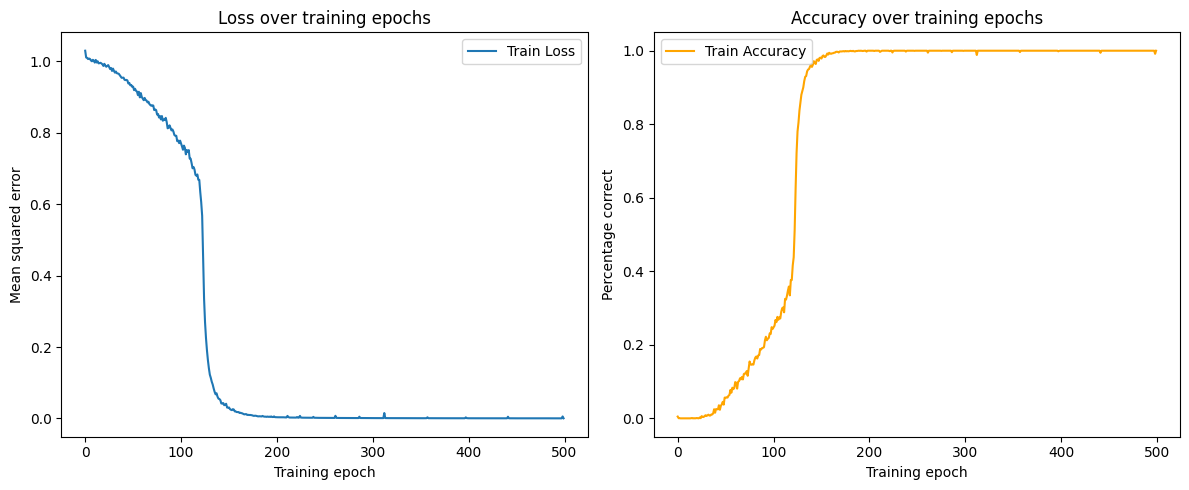

In [11]:
# Visualize training metrics
plot_training_loss_accuracy(EPOCHS, metrics_history, 
                            save_loc='../results/phase_code_train_loss_accuracy.png')

## Plot dynamics of trained CT-RNN

In [12]:
# Initialize `ModelParameters` object
params = ModelParameters(train_state)

In [13]:
# Compute PCA
key, pca_key = random.split(key, num=2)
model_behavior, pca = compute_pca(
    pca_key,
    train_state,
    params.params,
    tf_dataset_train,
    3,
)

In [14]:
# Compute null rates
key, test_key = random.split(key, num=2)
output_null, rates_null = train_state.apply_fn(
    params.params, 
    jnp.zeros((1, TIME_LENGTH, MOD)), 
    rngs={"noise_stream": test_key}
)
rates_null_m3a = pca.transform(rates_null[0,:,:])

In [15]:
output_accept_dict = {0: model_behavior['outputs'][0, :, 0]}
output_reject_dict = {4: model_behavior['outputs'][4, :, 0]}

blue_gradient = interpolate_colors("#7f7f7f", "#1f77b4", n_steps=TIME_LENGTH)
orange_gradient = interpolate_colors("#7f7f7f", "#ff7f0e", n_steps=TIME_LENGTH)

trajectory_indices_m3a = [0, 4]
trajectory_colors_m3a = {
    0: blue_gradient, 
    4: orange_gradient,
}
classification_colors_m3a = {
    (1,): 'tab:blue', 
    (-1,): 'tab:orange',
}

In [16]:
# Define colors for integer stimuli
stimulus_colors_m3a = {0: "tab:green", 1: "tab:red", 2: "tab:purple"}

# Decode integer sequences for example trials
decoded_accept = task.decode_integer_inputs(model_behavior['inputs'][0, :, :],)
decoded_reject = task.decode_integer_inputs(model_behavior['inputs'][4, :, :],)

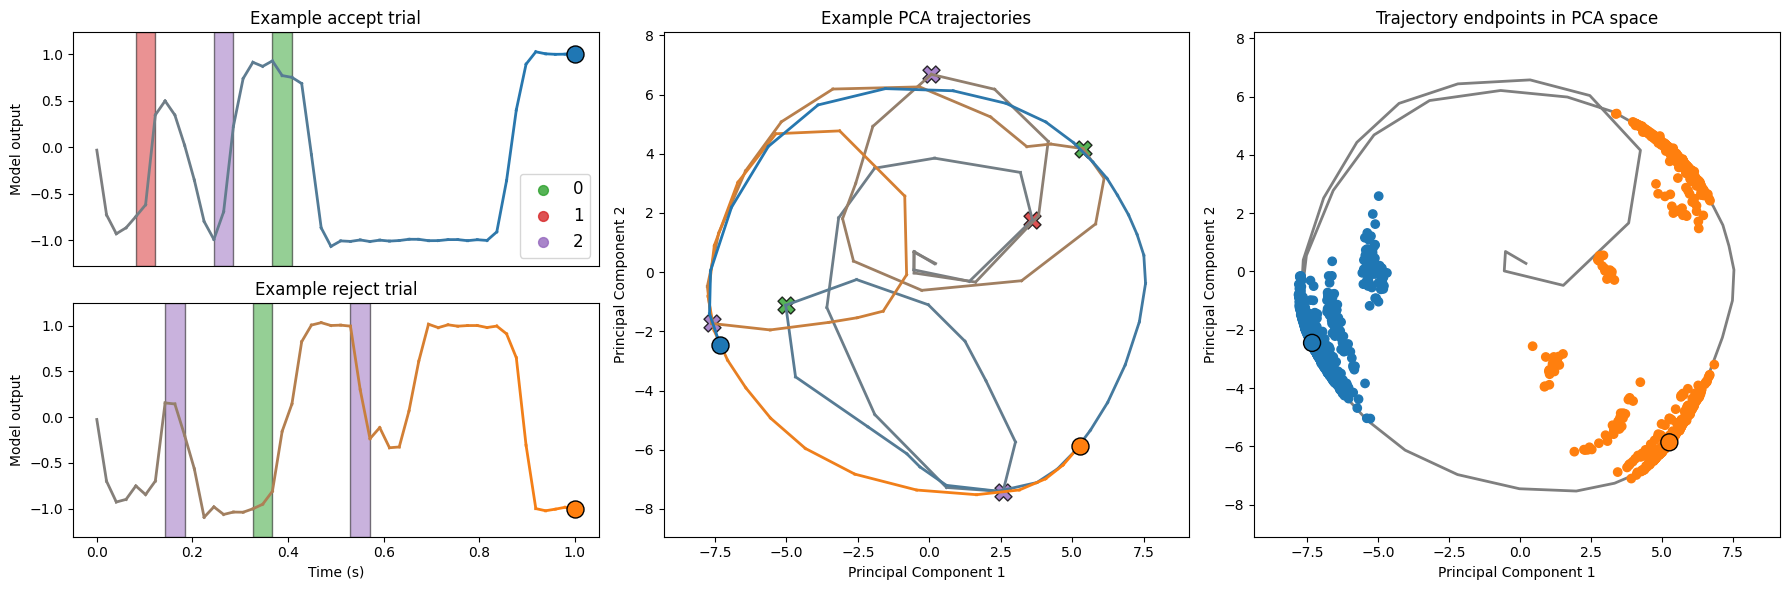

In [17]:
# Create the Figure
fig_anim = plt.figure(figsize=(18, 6))
gs = GridSpec(2, 3)

# Panel 1
ax_1 = fig_anim.add_subplot(gs[0, 0])
animator_1 = OutputAnimator(
    ax_1, output_accept_dict, trajectory_colors_m3a,
    title='Example accept trial', stimulus_colors=stimulus_colors_m3a,
)
animator_1.color_integer_bars(decoded_accept,)
animator_1.add_stimulus_legend()
ax_1.set_xticks([])
ax_1.set_xlabel('')
animator_1.figure()

# Panel 2
ax_2 = fig_anim.add_subplot(gs[1, 0,])
animator_2 = OutputAnimator(
    ax_2, output_reject_dict, trajectory_colors_m3a,
    title='Example reject trial', stimulus_colors=stimulus_colors_m3a,
)
animator_2.color_integer_bars(decoded_reject,)
animator_2.figure()

# Panel 3
ax_3 = fig_anim.add_subplot(gs[:, 1])
animator_3 = PCATrajectoryAnimator(
    ax_3, model_behavior, 1, 2, 
    trajectory_indices_m3a, trajectory_colors_m3a, 
    'Example PCA trajectories', stimulus_colors=stimulus_colors_m3a,
)
animator_3.color_integer_points(0, decoded_accept,)
animator_3.color_integer_points(4, decoded_reject,)
animator_3.figure()

# Panel 4
ax_4 = fig_anim.add_subplot(gs[:, 2,])
animator_4 = PCAPopulationAnimator(
    ax_4, model_behavior, 1, 2, classification_colors_m3a,
    example_trajectory=rates_null_m3a, highlight_indices=trajectory_indices_m3a,
    title='Trajectory endpoints in PCA space',
)
animator_4.figure()

plt.tight_layout()
plt.show()

## Save parameters

In [18]:
params.serialize("../data/phase_code_solution_m3a_task.bin")